# Import ABSGD
### Author: Qi Qi

In [22]:
!pip3 install absgd

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from absgd.losses import ABLoss
from absgd.optimizers import ABSGD, ABAdam
from absgd.datasets import IMBALANCECIFAR10, IMBALANCECIFAR100
from torchvision import transforms, datasets
import torch
import numpy as np

/home/qqi7/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### DataLoader Pipelines

<code>imb_type</code> (str): 'exp', 'step' (default: 'exp')\
<code>imb_factor</code> (float): (default : 0.1)

In [3]:
transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_root = './data/'
batch_size = 128
imb_factor = 0.1
imb_type = 'exp'
rand_number = 7
train_set = IMBALANCECIFAR10(root = data_root, imb_type= imb_type, imb_factor= imb_factor,
                                             rand_number = rand_number, train=True, download=True,
                                             transform = transform_train)
val_set = datasets.CIFAR10(root = data_root, train=False, download=True, transform=transform_val)

train_loader = torch.utils.data.DataLoader(
            train_set, batch_size= batch_size, shuffle=True,
            num_workers= 2, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
            val_set, batch_size = batch_size, shuffle=False,
            num_workers= 2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Improt models

In [4]:
import os
from models import resnet18
gpu_id = 1
arch = 'resnet18'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
use_cuda = torch.cuda.is_available()
set_all_seeds(rand_number)
model = resnet18(num_classes = 10)
model = torch.nn.DataParallel(model).cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{}: {} Number of paramters in total'.format(arch, pytorch_total_params))
# print(model)

resnet18: 11181642 Number of paramters in total


# ABloss, criterion, optimizer and hyperparameters

In [23]:

import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR 
milestones = [160, 230]
mylambda = 0.5
epochs = 300
# this can be easily combined with existing CBCE, LDAM loss, please refer our paper https://arxiv.org/pdf/2012.06951.pdf
criterion =  nn.CrossEntropyLoss(reduction='none') 
optimizer = ABSGD(model.parameters(), lr = 0.1,  weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.05)
abloss = ABLoss(mylambda, milestone = 160, criterion = criterion, abgamma = 0.9, abalpha =1)
print(abloss.milestone, abloss.criterion, abloss.abgamma, abloss.mylambda, abloss.abalpha)


160 CrossEntropyLoss() 0.9 0.5 1


In [6]:
def validate(val_loader, model):
    '''
    return loss, accuracy, aumm, auden after every epochs
    '''
    model.eval()
    CE_criterion = nn.CrossEntropyLoss(reduction = 'none')
    with torch.no_grad():
        val_acc = [] # record the accuracy for each sample for aumm and den estimation.
        val_loss = []
        for i, (inputs, targets) in enumerate(val_loader):
            targets = targets.cuda(non_blocking = True)
            inputs = inputs.cuda(non_blocking = True)
            # compute output
            outputs = model(inputs)
            pred_target = torch.argmax(outputs, dim = 1)
            sample_acc = (targets == pred_target)*1
            val_acc.extend(sample_acc.tolist())
            loss = CE_criterion(outputs, targets)
            val_loss.extend(loss.tolist())
          
        val_acc = np.array(val_acc)
        mean_acc = np.mean(val_acc)
        mean_loss = np.mean(val_loss)
    return mean_loss, mean_acc

In [8]:
#train
# for plot
train_acc_arr, val_acc_arr = [], []
train_loss_arr, val_loss_arr = [], []
for epoch in range(epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        losses = abloss(outputs, targets)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    abloss.updateLambda()
    scheduler.step()
    train_loss, train_acc = validate(train_loader, model)
    val_loss, val_acc = validate(val_loader, model)
    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)
    
    # test_loss, test_acc, test_aumm, test_den = validate(test_loader, test_proxy_embed, model, test_attr_dat, test_id, test_den_loader)
    print('Epoch: {}/{} epoch, lr: {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, epochs, optimizer.param_groups[0]['lr'], train_loss, train_acc, val_loss, val_acc))

    

Epoch: 0/300 epoch, lr: 0.1, train_loss: 1.6344, train_acc: 0.4459, val_loss: 2.1993, val_acc: 0.2485
None
Epoch: 1/300 epoch, lr: 0.1, train_loss: 1.5000, train_acc: 0.4668, val_loss: 2.1143, val_acc: 0.2574
None
Epoch: 2/300 epoch, lr: 0.1, train_loss: 1.3935, train_acc: 0.5000, val_loss: 1.8752, val_acc: 0.3216
None
Epoch: 3/300 epoch, lr: 0.1, train_loss: 1.3558, train_acc: 0.5221, val_loss: 1.8138, val_acc: 0.3571
None
Epoch: 4/300 epoch, lr: 0.1, train_loss: 1.3164, train_acc: 0.5339, val_loss: 1.7432, val_acc: 0.3687
None
Epoch: 5/300 epoch, lr: 0.1, train_loss: 1.2251, train_acc: 0.5606, val_loss: 1.6762, val_acc: 0.3937
None
Epoch: 6/300 epoch, lr: 0.1, train_loss: 1.1602, train_acc: 0.5797, val_loss: 1.6025, val_acc: 0.4261
None
Epoch: 7/300 epoch, lr: 0.1, train_loss: 1.1543, train_acc: 0.5918, val_loss: 1.4424, val_acc: 0.4913
None
Epoch: 8/300 epoch, lr: 0.1, train_loss: 1.0546, train_acc: 0.6253, val_loss: 1.4202, val_acc: 0.5029
None
Epoch: 9/300 epoch, lr: 0.1, train_lo

Epoch: 76/300 epoch, lr: 0.1, train_loss: 0.3343, train_acc: 0.8844, val_loss: 0.9516, val_acc: 0.7253
None
Epoch: 77/300 epoch, lr: 0.1, train_loss: 0.3446, train_acc: 0.8788, val_loss: 1.0004, val_acc: 0.7198
None
Epoch: 78/300 epoch, lr: 0.1, train_loss: 0.2996, train_acc: 0.8955, val_loss: 1.0790, val_acc: 0.7082
None
Epoch: 79/300 epoch, lr: 0.1, train_loss: 0.3023, train_acc: 0.8935, val_loss: 0.9411, val_acc: 0.7295
None
Epoch: 80/300 epoch, lr: 0.1, train_loss: 0.2749, train_acc: 0.9020, val_loss: 0.9970, val_acc: 0.7142
None
Epoch: 81/300 epoch, lr: 0.1, train_loss: 0.2586, train_acc: 0.9095, val_loss: 1.0242, val_acc: 0.7182
None
Epoch: 82/300 epoch, lr: 0.1, train_loss: 0.2799, train_acc: 0.8994, val_loss: 1.0444, val_acc: 0.7144
None
Epoch: 83/300 epoch, lr: 0.1, train_loss: 0.2715, train_acc: 0.9032, val_loss: 0.9007, val_acc: 0.7449
None
Epoch: 84/300 epoch, lr: 0.1, train_loss: 0.2628, train_acc: 0.9068, val_loss: 1.0518, val_acc: 0.7164
None
Epoch: 85/300 epoch, lr: 0.1

Epoch: 152/300 epoch, lr: 0.1, train_loss: 0.1764, train_acc: 0.9385, val_loss: 1.1419, val_acc: 0.7308
None
Epoch: 153/300 epoch, lr: 0.1, train_loss: 0.2073, train_acc: 0.9261, val_loss: 1.2578, val_acc: 0.7113
None
Epoch: 154/300 epoch, lr: 0.1, train_loss: 0.1850, train_acc: 0.9366, val_loss: 1.1452, val_acc: 0.7293
None
Epoch: 155/300 epoch, lr: 0.1, train_loss: 0.1594, train_acc: 0.9436, val_loss: 1.0864, val_acc: 0.7347
None
Epoch: 156/300 epoch, lr: 0.1, train_loss: 0.1524, train_acc: 0.9468, val_loss: 1.0140, val_acc: 0.7592
None
Epoch: 157/300 epoch, lr: 0.1, train_loss: 0.1959, train_acc: 0.9320, val_loss: 1.1602, val_acc: 0.7117
None
Epoch: 158/300 epoch, lr: 0.1, train_loss: 0.2185, train_acc: 0.9222, val_loss: 1.3156, val_acc: 0.6923
None
Epoch: 159/300 epoch, lr: 0.005000000000000001, train_loss: 0.1699, train_acc: 0.9397, val_loss: 1.0808, val_acc: 0.7303
0.5
Epoch: 160/300 epoch, lr: 0.005000000000000001, train_loss: 0.7853, train_acc: 0.8546, val_loss: 1.0518, val_acc

Epoch: 219/300 epoch, lr: 0.005000000000000001, train_loss: 0.1774, train_acc: 0.9748, val_loss: 0.7889, val_acc: 0.7464
0.5
Epoch: 220/300 epoch, lr: 0.005000000000000001, train_loss: 0.2008, train_acc: 0.9660, val_loss: 0.7651, val_acc: 0.7453
0.5
Epoch: 221/300 epoch, lr: 0.005000000000000001, train_loss: 0.1668, train_acc: 0.9741, val_loss: 0.7279, val_acc: 0.7639
0.5
Epoch: 222/300 epoch, lr: 0.005000000000000001, train_loss: 0.1652, train_acc: 0.9774, val_loss: 0.7276, val_acc: 0.7635
0.5
Epoch: 223/300 epoch, lr: 0.005000000000000001, train_loss: 0.1988, train_acc: 0.9627, val_loss: 0.7747, val_acc: 0.7479
0.5
Epoch: 224/300 epoch, lr: 0.005000000000000001, train_loss: 0.2624, train_acc: 0.9438, val_loss: 0.8930, val_acc: 0.7136
0.5
Epoch: 225/300 epoch, lr: 0.005000000000000001, train_loss: 0.2103, train_acc: 0.9700, val_loss: 0.7910, val_acc: 0.7375
0.5
Epoch: 226/300 epoch, lr: 0.005000000000000001, train_loss: 0.1779, train_acc: 0.9771, val_loss: 0.7900, val_acc: 0.7408
0.5


Epoch: 284/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0577, train_acc: 0.9952, val_loss: 0.7711, val_acc: 0.7773
0.5
Epoch: 285/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0589, train_acc: 0.9939, val_loss: 0.7754, val_acc: 0.7756
0.5
Epoch: 286/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0576, train_acc: 0.9949, val_loss: 0.7933, val_acc: 0.7715
0.5
Epoch: 287/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0571, train_acc: 0.9949, val_loss: 0.7738, val_acc: 0.7786
0.5
Epoch: 288/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0574, train_acc: 0.9938, val_loss: 0.7720, val_acc: 0.7781
0.5
Epoch: 289/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0558, train_acc: 0.9947, val_loss: 0.7842, val_acc: 0.7737
0.5
Epoch: 290/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0557, train_acc: 0.9948, val_loss: 0.7840, val_acc: 0.7765
0.5
Epoch: 291/300 epoch, lr: 0.00025000000000000006, train_loss: 0.0561, train_acc: 0.9947, val_loss: 0.7772, val_

**CE**: lr = 0.1, milestones = 160, 230, gamma = 0.05 train accuracy: 0.9991 test accuracy: 0.7745 \
**ABSGD**: lr = 0.1, milestones = 160, 230, gamma = 0.05, abgamma 0.9, lambda 0.5 ,  train accuracy: 0.9954 test accuracy: 0.7798

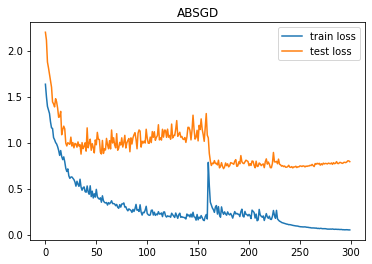

In [24]:
import matplotlib.pyplot as plt
train_loss_arr1 = train_loss_arr
val_loss_arr1 = val_loss_arr
plt.plot(train_loss_arr1, label = 'train loss')
plt.plot(val_loss_arr1, label = 'test loss')
plt.title('ABSGD')
plt.legend()
plt.show()

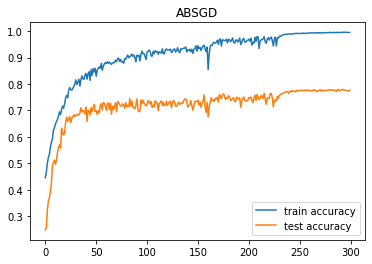

In [25]:
train_acc_arr1 = train_acc_arr
val_acc_arr1 = val_acc_arr
plt.plot(train_acc_arr1, label = 'train accuracy')
plt.plot(val_acc_arr1, label = 'test accuracy')
plt.title('ABSGD')
plt.legend()
plt.show()